#Data insight
In the discrete questions, success was defined and evaluated for the whole 10 days.  What does it compare to.  Let's first look at the overall success over the for days.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
import sys
sys.path.append('../')
import click_succ
import time_click
filename = '../data/train.csv'

In [2]:
#df = pd.read_csv(filename, dtype={'id': str},nrows=10000000)
df = pd.read_csv(filename, dtype={'id': str})
#df = pd.read_pickle('../data/df_10000.pkl')
#df = pd.read_pickle('../data/df_9000000.pkl')
df['time'] = pd.to_datetime(df['hour'], format='%y%m%d%H')
df.set_index('time', inplace=True)

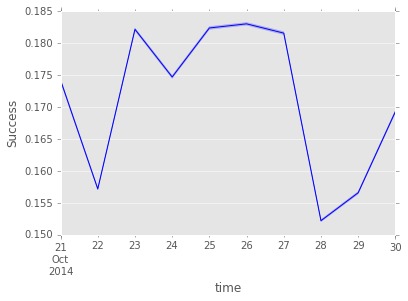

In [3]:
_ = time_click.plot_success_trend(time_click.get_success_time_series(df, 'D'))

So the overall success is between 0.15 and 0.2, i.e. 15-20%.
That is much higher than typical click-through rate [usually much smaller than 1%](http://www.imediaconnection.com/content/25781.asp#multiview).  This is explained in the kaggle [forum](https://www.kaggle.com/c/avazu-ctr-prediction/forums/t/10782/q-a), where the organizers explains that they "have subsampled much fewer non-click records, which makes the CTR really high".

##Comparing the most successful fields

In [4]:
fields = df.columns
fields = [x for x in fields if x not in ('hour', 'click')]
success_tups = []
df_dic = {}
for ifield in fields:
    idf = click_succ.get_most_successfuls_df(df, ifield, 30, False)
    if idf is None:
        continue
    df_dic[ifield] = idf
    success_tups.append((ifield, idf.success.tolist()[0], idf.success_std.tolist()[0]))
success_tups.sort(key = lambda t: t[1], reverse=True)


Error: not enough clicks to satisfy threshold conditions



In [5]:
fields, successes, stds = zip(*success_tups)

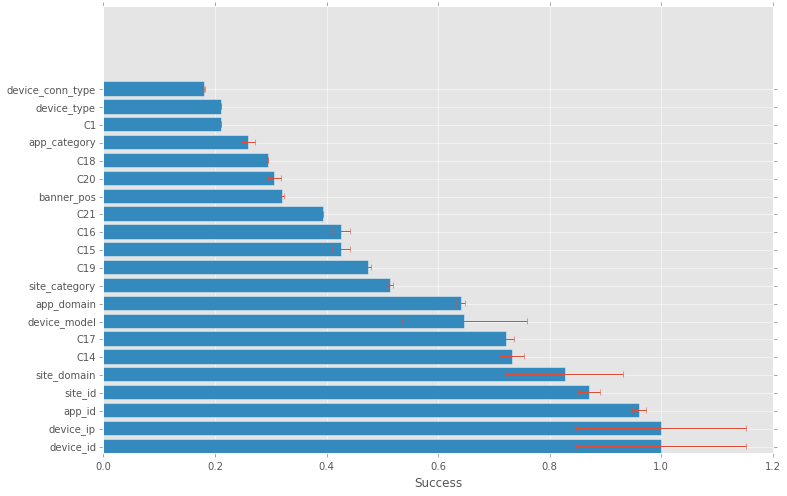

In [6]:
fig_success_fields = plt.figure(figsize=(12,8))
index = np.arange(len(successes))
bar_width = 0.35
plt.barh(index, successes, xerr=stds)
plt.xlabel('Success')
_ = plt.yticks(index + bar_width, fields)

There are two fields that have a perfect success rate: `device_ip` and `devide_id`.  Let's make sure they are nothing wrong with this field.

In [7]:
df_dic["device_id"].head()

,clicked,notclicked,success,success_std
9c5f6296,43,0,1,0.152499
c43c3869,38,0,1,0.162221
98ba1dd7,47,0,1,0.145865
5a91b085,42,0,1,0.154303
f135a004,39,0,1,0.160128


These are low numbers (as suggested by the error bars) but nothing seems weird about it. Here is the distribution of all `device_ip` without click threshold to catch them all.

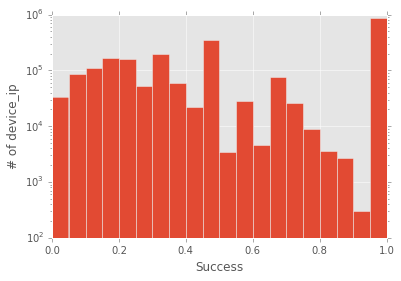

In [9]:
clk_thrd = 0
df_devip = click_succ.get_most_successfuls_df(df, "device_ip", clk_thrd, False)
df_devip['success'].hist(bins=20)
plt.yscale('log')
plt.xlabel('Success')
_ = plt.ylabel('# of device_ip')

Most of the spectrum is covered (note the log scale), but there are so much of those categories, some are bound to be successful.  Similarly there are similar results for the device_id.

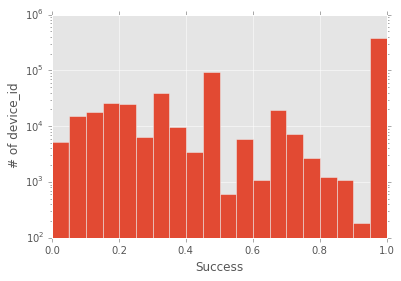

In [10]:
df_devid = click_succ.get_most_successfuls_df(df, "device_id", clk_thrd, False)
df_devid['success'].hist(bins=20)
plt.yscale('log')
plt.xlabel('Success')
_ = plt.ylabel('# of device_id')

##A closer look at the most successful app_domain
In the discrete questions, the most successful app_domains were:
['99b4c806', '73fc6786', 'eaaf6d12', 'f5a7c834']
Let's look at their results on a daily basis.

In [11]:
top_app_domain = ['99b4c806', '73fc6786', 'eaaf6d12', 'f5a7c834']

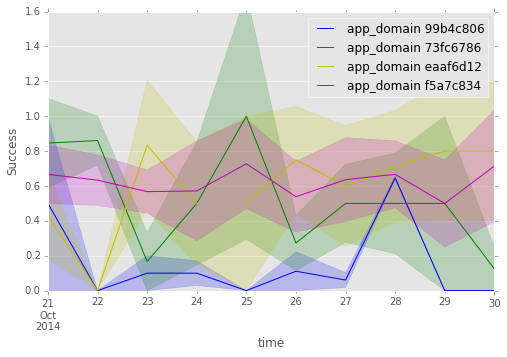

In [19]:
fig_top_app_dom = plt.figure(figsize=(8,5))
time_click.plot_success_trends(df, "app_domain", top_app_domain)
_ = plt.ylim(0, 1.6)

One app stands out by having quite a low success rate, but a sudden jump on the 28th.
Moreover the validity bands gets narrower, revealing high statistics on that day.
Let look at the number of impressions (# of clicked + # of not clicked):

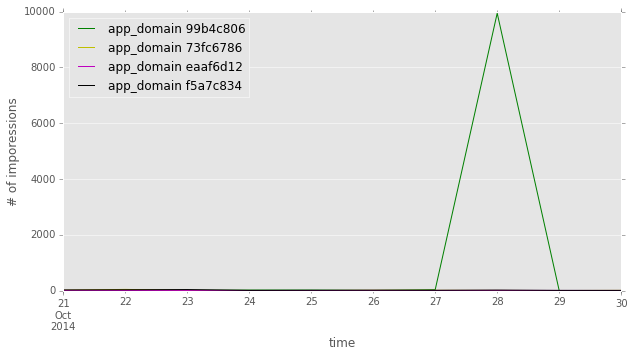

In [13]:
fig_app = plt.figure(figsize=(10,5))
_ = time_click.plot_impression_trends(df, "app_domain", top_app_domain)

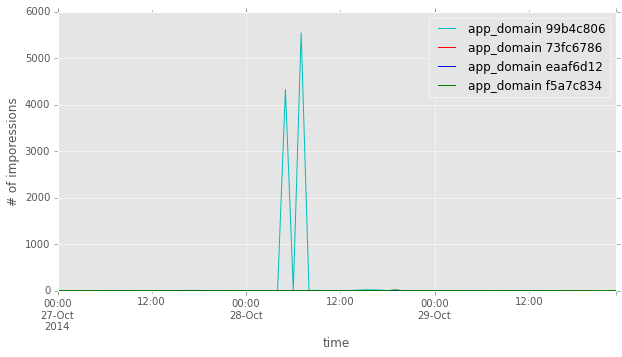

In [14]:
fig_app_by_hours = plt.figure(figsize=(10,5))
_ = time_click.plot_impression_trends(df[(df.index.day>=27) & (df.index.day<=29)], "app_domain", top_app_domain, "H")

So `app_domain=99b4c806` is successful only because of those event "bursts" unusual in time, but
statistically dominating.